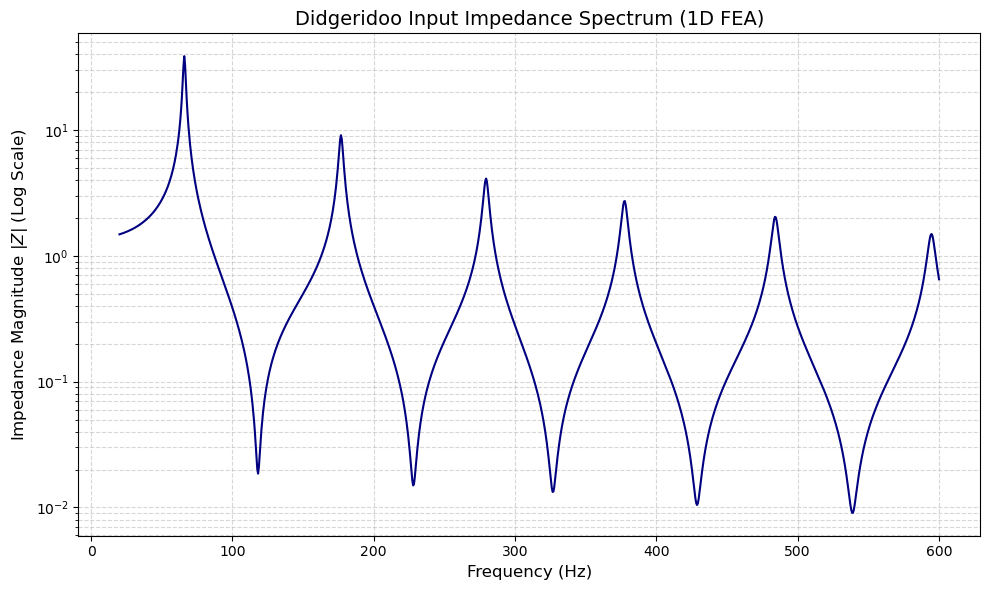

In [2]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt

# 1. Geometry and Constants
# Didgeridoo: [distance, diameter] in mm
segments = np.array([[0, 32], [1200, 40], [1600, 70]])  
c = 343000.0  # Speed of sound in mm/s
frequencies = np.linspace(20, 600, 1000)  # Hz

x_coords = segments[:, 0]
diameters = segments[:, 1]

def get_area(x):
    d = np.interp(x, x_coords, diameters)
    return np.pi * (d / 2.0)**2

# 2. Mesh and Basis
mesh = fem.MeshLine(np.linspace(0, x_coords[-1], 600))
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

# 3. Define Forms
def stiffness_fun(u, v, w):
    return get_area(w.x[0]) * dot(grad(u), grad(v))

def mass_fun(u, v, w):
    return get_area(w.x[0]) * u * v

K = fem.BilinearForm(stiffness_fun).assemble(basis)
M = fem.BilinearForm(mass_fun).assemble(basis)

# 4. Boundary Setup
# Bell end: Pressure = 0 (Dirichlet)
bell_dof_data = basis.get_dofs(lambda x: np.isclose(x[0], x_coords[-1])).nodal
# Extract indices from dictionary if necessary
bell_dofs = np.concatenate([v for v in bell_dof_data.values()]) if isinstance(bell_dof_data, dict) else bell_dof_data

# Mouthpiece: Setup the source vector
b_mouth = np.zeros(basis.N)

# FIXED: Safely extract nodal indices from the Dofs object (handling dict structure)
mouth_dof_data = basis.get_dofs(lambda x: np.isclose(x[0], 0)).nodal
if isinstance(mouth_dof_data, dict):
    mouth_indices = np.concatenate([v for v in mouth_dof_data.values()]).astype(int)
else:
    mouth_indices = np.array(mouth_dof_data).astype(int)

b_mouth[mouth_indices] = 1.0 

# 5. Frequency Sweep
impedance_magnitude = []

# Add viscothermal damping to prevent infinite peaks and simulate wall friction
# damping factor alpha is proportional to sqrt(frequency)
for f in frequencies:
    omega = 2 * np.pi * f
    k = (omega / c) - 1j * (2e-6 * np.sqrt(f)) 
    k_sq = k**2
    
    A = K - k_sq * M
    
    # Solve for complex pressure p
    p = fem.solve(*fem.condense(A, b_mouth, D=bell_dofs))
    
    # Input Impedance Z = p_mouth / U_mouth. Since U=1, Z = p[mouth]
    z_val = p[mouth_indices[0]]
    impedance_magnitude.append(np.abs(z_val))

# 6. Visualization


plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, impedance_magnitude, color='navy', linewidth=1.5)
plt.title("Didgeridoo Input Impedance Spectrum (1D FEA)", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Impedance Magnitude $|Z|$ (Log Scale)", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
import scipy
i = scipy.signal.find_peaks(impedance_magnitude)
frequencies[i[0]]


array([ 65.86586587, 176.75675676, 279.51951952, 377.63763764,
       483.88388388, 594.77477477])

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C2,-12.631656,-33,64.930901,23.998926,1.000000
1,F3,-7.631656,-16,173.846073,6.640184,0.276687
2,C#4,-27.631656,-8,272.793728,1.906460,0.079439
3,F#4,-7.631656,-3,368.366996,1.282197,0.053427
4,A#4,22.368344,1,472.225891,1.095542,0.045650
5,D5,-27.631656,5,578.029775,0.704364,0.029350
6,E5,-12.631656,7,654.462476,0.630788,0.026284
7,F#5,37.368344,9,756.134987,0.901504,0.037564
8,A5,-32.631656,12,863.568414,1.007926,0.041999
9,B5,-37.631656,14,966.527296,1.088289,0.045347


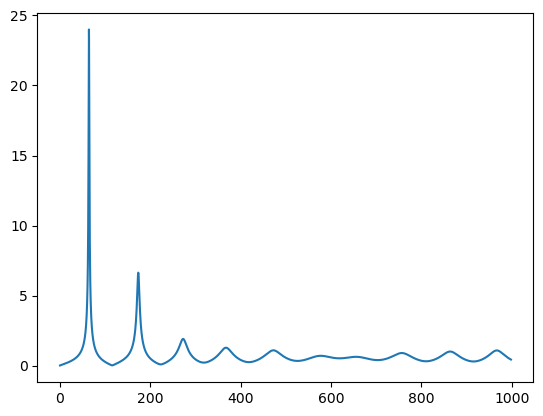

In [19]:
import sys
sys.path.append("../../")

from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies
from didgelab.calc.geo import Geo, geotools

geo = [[0, 32], [1200, 40], [1600, 70]]
geo = Geo(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances)
plt.plot(freqs, impedances)
notes


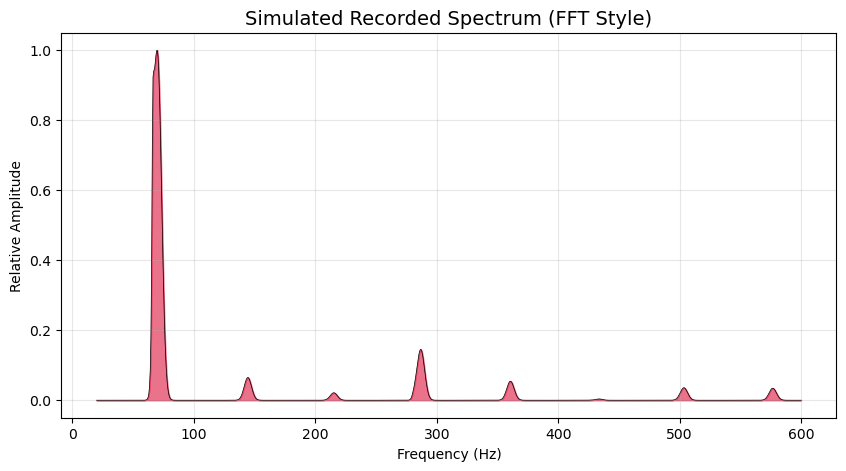

In [8]:
def get_realistic_fft(freqs, impedance, drone_freq=72, width=3):
    """
    freqs: frequency array from FEM
    impedance: impedance magnitude from FEM
    drone_freq: fundamental frequency of the lips
    width: The 'width' of the spectral peaks in Hz
    """
    spectrum = np.zeros_like(freqs)
    
    # Calculate how many harmonics fit in our range
    max_h = int(freqs[-1] / drone_freq)
    
    for h in range(1, max_h + 1):
        target_f = h * drone_freq
        
        # Create a Gaussian peak for this harmonic
        # Amplitude decreases with harmonic number (1/h)
        harmonic_energy = (1.0 / h) * np.exp(-0.5 * ((freqs - target_f) / width)**2)
        
        # Add to the total spectrum
        spectrum += harmonic_energy
    
    # Apply the Filter (Impedance) and Radiation (freqs)
    # FFT = Source * Filter * Radiation
    simulated_fft = spectrum * impedance * freqs
    
    # Normalize
    simulated_fft /= np.max(simulated_fft)
    return simulated_fft

# Calculate
realistic_fft = get_realistic_fft(frequencies, np.array(impedance_magnitude))

# Visualization
plt.figure(figsize=(10, 5))
plt.fill_between(frequencies, realistic_fft, color='crimson', alpha=0.6)
plt.plot(frequencies, realistic_fft, color='black', linewidth=0.5)
plt.title("Simulated Recorded Spectrum (FFT Style)", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Relative Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
simulated_fft

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     